In [18]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import torch
import transformers as ppb
import warnings
import os
import itertools
from src.data.make_dataset import read_data_file
from src.data.make_dataset import make_dataset
from IPython.display import clear_output
import matplotlib.pyplot as plt
from random import sample
from sklearn.metrics import classification_report
from collections import OrderedDict 
from random import shuffle
warnings.filterwarnings('ignore')

In [2]:
assert os.path.isdir("csv"), 'The directory "csv" does not exist!'
assert os.path.isdir("txt"), 'The directory "txt" does not exist!'
map_contents = read_data_file("csv/Map_Contents-20200726.csv")
speech_contents = read_data_file("csv/Speech_Contents-20210520.txt")
speeches = read_data_file("csv/Speeches-20210520.txt")

In [3]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def shuffle_(dict_x,dict_y):
    b = list(zip(dict_x.items(),dict_y.items()))
    shuffle(b)
    c,d = zip(*b)
    c = dict(OrderedDict(c)) 
    d = dict(OrderedDict(d)) 
    return (c,d)

def balance_data(X,y):
    true_X = {}
    false_X = {}
    true_y = {}
    false_y = {}
    
    #Obtain data that its corresponding labels are True and False
    for ind in X:
        if y[ind] == False:
            false_X[ind] = X[ind]
            false_y[ind] = y[ind]
        elif y[ind] == True:
            true_X[ind] = X[ind]
            true_y[ind] = y[ind]    
        else:
            print('Encounter None True and False label!',X[ind],y[ind])
            
    assert len(false_X) == len(false_y), 'The length between X and y are not the same!'
    assert len(true_X) == len(true_y), 'The length between X and y are not the same!'
    
    #count how many of sentence are True, False
    print('We totally have {} True and {} False data.'.format(len(true_X), len(false_X)))
    all_true_ind = list(true_X)
    sampled_true_ind = sample(all_true_ind,len(false_X)) 
    
    X_pre={}
    y_pre={}
    for ind in sampled_true_ind:
        X_pre[ind] = X[ind]
        y_pre[ind] = y[ind]
    
    New_X = false_X.copy()
    New_X.update(X_pre)
    New_y = false_y.copy()
    New_y.update(y_pre)
    
    #Suffle the data for X and y (but remaining order of X and y are the same)
    New_X,New_y = shuffle_(New_X,New_y)
    
    return (New_X,New_y)  

In [4]:
X, y = make_dataset(speeches, speech_contents, map_contents)
New_X, New_y = balance_data(X,y)

skipping file in language fr: 2009-12-01 Sarkozy Elysee (Economy) ann fr.txt
skipping file in language fr: 2009-12-14 Sarkozy Elysee (Economy) ann fr.txt
skipping file in language fr: 2010-04-20 Barroso European Commission ann fr.txt
skipping file in language fr: 2011-01-13 Sarkozy gb ann.txt
skipping file in language nl: 2011-04-06 Rutte FD evenement ann NL.txt
skipping file in language nl: 2011-09-27 Rutte Rijksoverheid ann.txt
skipping file in language nl: 2011-10-28 Knot dnb_01 ANN NL.txt
skipping file in language de: 2012-01-06 Rutte CSU klausurtagung ann G.txt
skipping file in language unk: 2012-07-26 Barroso European Commission.txt
skipping file in language fr: 2012-08-30 Hollande SFM2020 ann fr.txt
skipping file in language fr: 2013-02-19 Hollande SFM2020 ann fr.txt
skipping file in language fr: 2013-04-17 Hollande SFM2020 ann fr.txt
skipping file in language de: 2013-11-21 Merkel Bundesregerung ann g.txt
skipping file in language de: 2014-02-27 Merkel Bundesregerung ann g.txt


### Mising data found:<Br>

In [5]:
print(y['207 8-1'])
print(X['207 8-1'])

True


KeyError: '207 8-1'

### Convert data to dataframe and drop those na rows

In [6]:
df = pd.DataFrame({'X':pd.Series(X),'y':pd.Series(y)})
batch_1 = df[:]

print('{} na data found\n'.format(len(batch_1[batch_1['X'].isna() == True].index)))

na_ind = batch_1[batch_1['X'].isna() == True].index

batch_1 = batch_1.drop(na_ind)

print('Check how many na rows were dropped:')
print(df['y'].value_counts(),'\n')

print(batch_1['y'].value_counts())

19 na data found

Check how many na rows were dropped:
True     660
False    237
Name: y, dtype: int64 

True     641
False    237
Name: y, dtype: int64


In [7]:
df = pd.DataFrame({'X':pd.Series(New_X),'y':pd.Series(New_y)})
batch_2 = df[:]

print('{} na data found \n'.format(len(batch_2[batch_2['X'].isna() == True].index)))

na_ind = batch_2[batch_2['X'].isna() == True].index

batch_2 = batch_2.drop(na_ind)
print('Check how many na rows were dropped:')
print(df['y'].value_counts(),'\n')

print(batch_2['y'].value_counts())

0 na data found 

Check how many na rows were dropped:
True     237
False    237
Name: y, dtype: int64 

True     237
False    237
Name: y, dtype: int64


## Loading the Pre-trained BERT model
Let's now load a pre-trained BERT model. 

In [8]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights).cuda() #use .cpu here if you dont have GPU

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Using bert to get the last_hidden_states

In [15]:
def get_max_len(batch):
    tokenized = batch['X'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    return max_len


def get_last_hidden_states(batch,max_len):
    tokenized = batch['X'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    
    
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) #here 509 is the maximal length
    #print(np.array(padded).shape)
    attention_mask = np.where(padded != 0, 1, 0)
    #print(attention_mask.shape)
    
    input_ids = torch.tensor(padded).cuda() 
    attention_mask = torch.tensor(attention_mask).cuda() 
    
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
        
    features = last_hidden_states[0][:,0,:].cpu().numpy()
    
    return (features,batch_1)

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
def get_features(batch_1):
    batch_size = 64
    f_cat = np.array([])
    batch_truns = len(list(chunks(batch_1[:],batch_size)))
    
    max_len = get_max_len(batch_1)
    for b in range(batch_truns):
        print(f"Processed {b/batch_truns}")
        
        batch = list(chunks(batch_1[:],batch_size))[b]
        
    
        features,_ = get_last_hidden_states(batch,max_len)
        
            
        f_cat =  np.concatenate((f_cat, features), axis=0)if f_cat.size else features#np.vstack([f_cat, features]) if f_cat.size else features
        print(f_cat.shape)
    return f_cat

### Now use the hidden states we got to input in a simple Logistic regression classifier

In [16]:
def run_bert_approach(batch_1):
    features = get_features(batch_1)
    labels = batch_1['y']
    
    lr_clf = LogisticRegression(penalty='l2')
    lr_clf.fit(features, labels)

    y_pred = lr_clf.predict(features)
    target_names = ['class 0', 'class 1']
    print(classification_report(labels, y_pred, target_names=target_names))
    
    cm = sklearn.metrics.confusion_matrix(labels, y_pred)
    plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)
    
    return

Processed 0.0
(64, 768)
Processed 0.07142857142857142
(128, 768)
Processed 0.14285714285714285
(192, 768)
Processed 0.21428571428571427
(256, 768)
Processed 0.2857142857142857
(320, 768)
Processed 0.35714285714285715
(384, 768)
Processed 0.42857142857142855
(448, 768)
Processed 0.5
(512, 768)
Processed 0.5714285714285714
(576, 768)
Processed 0.6428571428571429
(640, 768)
Processed 0.7142857142857143
(704, 768)
Processed 0.7857142857142857
(768, 768)
Processed 0.8571428571428571
(832, 768)
Processed 0.9285714285714286
(878, 768)
              precision    recall  f1-score   support

     class 0       0.89      0.52      0.66       237
     class 1       0.85      0.98      0.91       641

    accuracy                           0.85       878
   macro avg       0.87      0.75      0.78       878
weighted avg       0.86      0.85      0.84       878



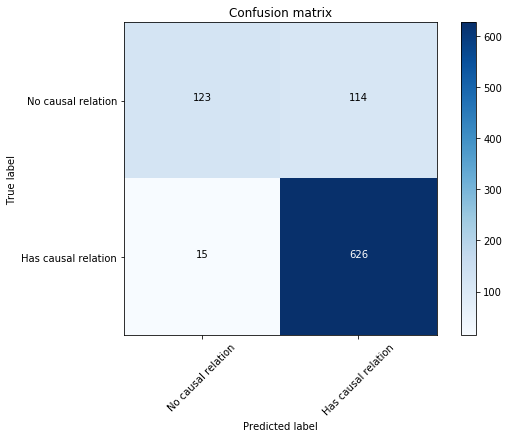

In [19]:
run_bert_approach(batch_1)

Processed 0.0
(64, 768)
Processed 0.125
(128, 768)
Processed 0.25
(192, 768)
Processed 0.375
(256, 768)
Processed 0.5
(320, 768)
Processed 0.625
(384, 768)
Processed 0.75
(448, 768)
Processed 0.875
(474, 768)
              precision    recall  f1-score   support

     class 0       0.85      0.82      0.84       237
     class 1       0.83      0.85      0.84       237

    accuracy                           0.84       474
   macro avg       0.84      0.84      0.84       474
weighted avg       0.84      0.84      0.84       474



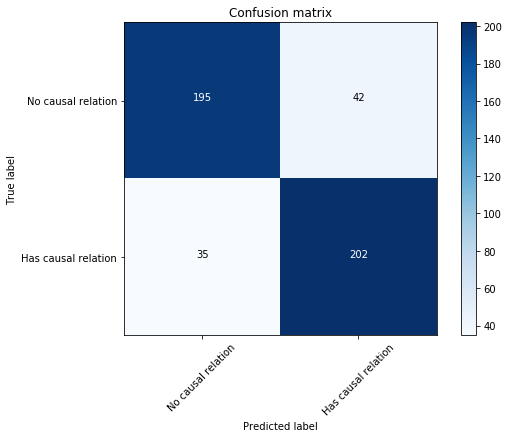

In [20]:
run_bert_approach(batch_2)

## Conclusion


Bert/n-gram| Balanced_data | precision(macro) | recall(macro) | F1(macro)|
 ----------| --------------| --------- | ------ | ---- |
3-gram(pre-trained WE)| no        | 0.678    | 0.592  | 0.597 |
3-gram(pre-trained WE)| yes       | 0.678     | 0.677  | 0.677 |
3-gram           | no       | 0.866     | 0.506  | 0.435 |
3-gram           | yes       | 0.558     | 0.532  | 0.471 |
Bert| no        | 0.87     | 0.75 | 0.78 |
Bert| yes       | 0.84     | 0.84 | 0.84 |

#### Attention is all you need!
The next step would be to try [fine-tuning](https://huggingface.co/transformers/examples.html#glue) once we have more data